# Point cloud based surface defect detection with deep learning

### Author: Chen Lequn
#### Initial commit: 13 Jan, 2021

## **Notebook 1: point cloud pre-processing (summary from defect correction paper)**
## Objective
- Preprocessing the point cloud data: 
1. data standarisation - centered at zero coordinate, unit variance; 
2. Data labeling: add a fourth dimension to the dataset - marking all the points to "non-defective (flat)"; "machining (bulge)"; "AM repair (dent)"
- 3D shape fitting:
1. calculating surface normal vector and principle curvatures.
2. Methdologies: PCA, DeepFet Network (PointNet based network, ECCV 2020)
- Segmentation/Classification:
1. Automatic point cloud segmentation/classification based on PointNet
2. Explore various point cloud classification/segmentation algorithms from recent years 2017-2021 CVPR/IROS 


## Introduction
This notebook is for pre-processing the point cloud data
- Dataset (Given): x, y, z
- Point Cloud transformation and position calibration
- Basic point cloud visualization by python in the jupyterlab 
- Point cloud standarization in Python
- Contour extraction by DBSCAN clustering
- Different method for polygon infill 
- polygon and line intersection, segmentation
- Zig-zag path generation
- Integration of the defect correction toolpath generation algorithm

### Reference:
- A **summary** of Point Cloud Projects with deep learning: https://github.com/Yochengliu/awesome-point-cloud-analysis
- **DeepFit** Network: 3D surface fitting https://github.com/sitzikbs/DeepFit
- **PointNet**: Deep Learning on Point Sets for 3D Classification and Segmentation.
    - [github tensorflow](https://github.com/charlesq34/pointnet)
    - [Pytorch implementation on github](https://github.com/fxia22/pointnet.pytorch)

- **DGCNN** Dynamic Graph CNN for Learning on Point Clouds [github](https://github.com/WangYueFt/dgcnn)
    - Pytorch Geometric for Graph Neural Network: https://github.com/pyg-team/pytorch_geometric
    - Another implementation with more visualization: https://github.com/AnTao97/dgcnn.pytorch
    - 1.1k star, the fundamentals for a lot of works
 
- PointNet++ (https://github.com/charlesq34/pointnet2)

- CurveNet: state-of-the-art 3D Point Cloud Classification and shape segementation (https://github.com/tiangexiang/CurveNet#point-cloud-classification)

- **MMDetection3D** OpenMMLab's next-generation platform for general 3D object detection. __2k star__ [github](https://github.com/open-mmlab/mmdetection3d)
    - MMCV documentation wesite:https://mmcv.readthedocs.io/en/latest/#installation

- **MVTN**: Multi-View Transformation Network for 3D Shape Recognition [github](https://github.com/ajhamdi/MVTN) -- ICCV'21,best paper. 
    - A useful 3D pytorch rendering function can be used.
    - Based on **MVCNN 2015** [github](https://github.com/jongchyisu/mvcnn_pytorch)
   
- [**DeepGCNs**](https://github.com/lightaime/deep_gcns_torch)

- **Minkowski Engine** is an auto-diff neural network library for high-dimensional sparse tensors [github](https://github.com/NVIDIA/MinkowskiEngine)

- PointPillars for KITTI object detection (https://github.com/nutonomy/second.pytorch)

- PointRCNN(https://github.com/sshaoshuai/PointRCNN)

- PolyFit(https://github.com/LiangliangNan/PolyFit)

    
 PointNet paper: https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf
- PointNet Pytorch: https://github.com/fxia22/pointnet.pytorch
- PointNet tensorflow: https://github.com/charlesq34/pointnet
- MVTN (ICCV 2021): https://github.com/ajhamdi/MVTN

## Set up

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import pandas as pd
import open3d as o3d
import numpy as np
import math

from shapely.geometry import Polygon
from shapely.geometry import MultiLineString
from shapely.geometry import LineString
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon,LinearRing, MultiPoint

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
# %matplotlib auto
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "png_images")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "dataset")
XYZ_point_PATH = os.path.join(DATA_PATH, "xyz")
PCD_file_PATH = os.path.join(DATA_PATH, "pcd")
file_output_dir =  os.path.join(PROJECT_ROOT_DIR, "output_dir/surface_fitting_result")
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(file_output_dir, exist_ok=True)


## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys  
import os
import numpy as np
sys.path.insert(0, '../utils')

import utils_functions
from utils_functions import plot_line, plot_coords, color_isvalid, color_issimple, plot_line_isvalid, plot_line_issimple
from utils_functions import plot_bounds, add_origin, set_limits
from utils_functions import LinePolygonIntersectionPoints, sort_MultiPoint, LineInPolygonSegmentation, grid_line_creation, visualize_grid_line_generation
from utils_functions import reverse_MultiLineString, visualize_grid_polygon_segmentation, zig_zag_segmentation, visualize_grid_polygon_segmentation
from utils_functions import visualize_bulge_area, calculate_polygon_bondary_with_point_clusters
from ConcaveHull import ConcaveHull

In [3]:
BLUE = '#6699cc'
GRAY = '#999999'
DARKGRAY = '#333333'
YELLOW = '#ffcc33'
GREEN = '#339933'
RED = '#ff3333'
BLACK = '#000000'

COLOR_ISVALID = {
    True: BLUE,
    False: RED,
}

### 1. Point cloud processing by Open3D library

#### 1.1  Step 1, obtain, convert the point cloud data into desired format
The accepted format for open3d library are ply, pcd, txt, ect. 
The best practice is using the __pcd__ file format as default, as the it is consistent with other program.

### File IO by open3d

In [4]:
## File IO
print("Testing IO for point cloud ...")

##--------------read point cloud data, save to a open3d object--------------
# pcd = o3d.io.read_point_cloud(os.path.join(PCD_file_PATH, "32_seg.pcd"))
pcd = o3d.io.read_point_cloud(os.path.join(PCD_file_PATH, "30_seg_rot.pcd")) ## default point_cloud_example.pcd
print(pcd)

## write the point cloud into a pcd file
# o3d.io.write_point_cloud(os.path.join(DATA_PATH, "copy_of_points.pcd"), pcd)

Testing IO for point cloud ...
PointCloud with 21798 points.


### voxel grid downsampling - to reduce the points

In [5]:
print("Downsample the point cloud with a voxel of 0.5")
downsample_pcd = pcd.voxel_down_sample(voxel_size=0.3)

# o3d.visualization.draw_geometries([downsample_pcd])

Downsample the point cloud with a voxel of 0.5


## 2. Point cloud visualizaiton by matplotlib

### - calculate the mean Z value (mean height of the top surface)

In [6]:
# ---- using numpy to print all the points -------
points_np_array = np.asarray(pcd.points)
print("the points converted to numpy are: \n")
print(points_np_array)
#------extract x,y,z value of the points-----
# ------------standarization-----------
# bbdiag = float(np.linalg.norm(points_np_array.max(0) - points_np_array.min(0), 2))
# points_np_array = (points_np_array - points_np_array.mean(0))/bbdiag
# print("the points are: \n")
# print(points_np_array)

scale = 1
x = points_np_array[:,0]* scale ## from m to mm
y = points_np_array[:,1]*scale  ## from m to mm
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]*scale  ## from m to mm
print("the z value extracted:" )
print (z)

# --------mean height-------------------
z_mean = np.mean(z)
print("Z mean: " + str(z_mean))

z_min = np.amin(z)
z_max = np.amax(z)
print ("Z minimum: "+ str(z_min))
print ("Z max: "+ str(z_max))


the points converted to numpy are: 

[[-13.84774583 -14.73133736   0.47270684]
 [-13.99546204 -14.56224483   0.48745801]
 [-14.10493174 -14.4094093    0.4682581 ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]
the z value extracted:
[0.47270684 0.48745801 0.4682581  ... 1.68861493 1.68418764 1.7008424 ]
Z mean: 1.117028044460246
Z minimum: 0.0
Z max: 1.816255610021727


## Calculate the plane for segmentation

In [7]:
# tune the segmentation line
z_segment = z_max - 0.5

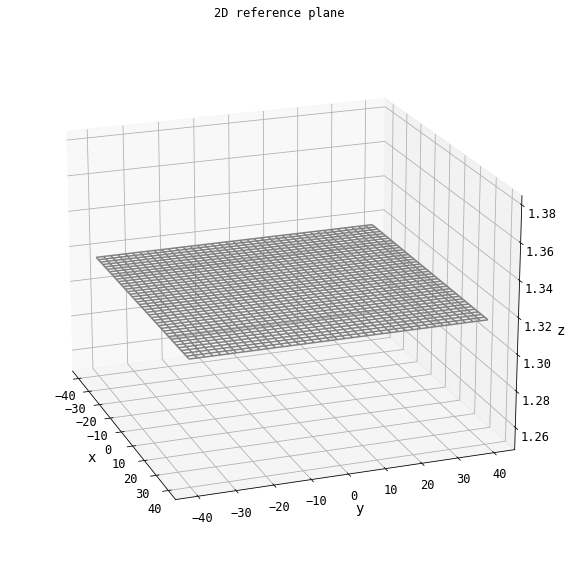

In [8]:
# Plot for a three-dimensional Plane
# this function is currently not used
def z_function(x, y):
    # ax+by+cz = d ---> z = -(ax+by-d)/c
    return  z_segment + 0 * x + 0 * y       

# create a plane with meshgrid (mainly for visualization purpose)
# x_plane = np.linspace(-11, 11, 30)
# y_plane = np.linspace(-21, 21, 30)
x_plane = np.linspace(-40, 40, 40)
y_plane = np.linspace(-40, 40, 40)

X, Y = np.meshgrid(x_plane, y_plane)
Z = z_function(X, Y) # the Z value (height) of the nominal plane is equal to the mean Z value of the point l
#print (X, Y, Z)


plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_wireframe(X, Y, Z, color='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('2D reference plane')

ax.view_init(elev=20,azim=-20) #rotate the graph
# save_fig("01_reference_plane")

Saving figure 02_visualization of 3D point cloud with the reference plane


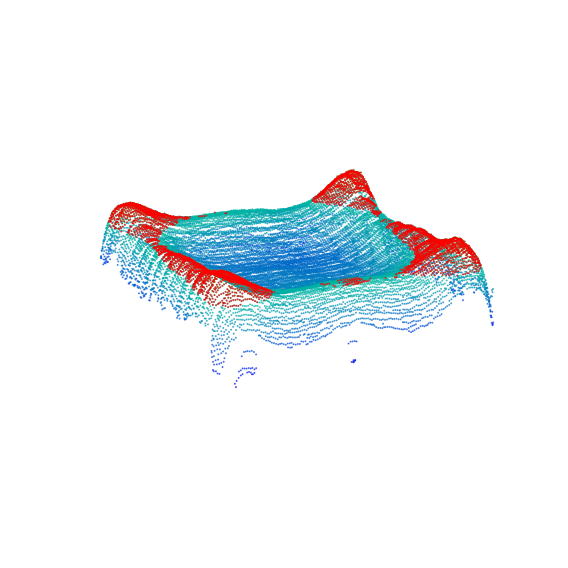

In [9]:
# this will make the plot interactive
# %matplotlib auto
x = points_np_array[:,0]
y = points_np_array[:,1]
points_np_array[:,2] = points_np_array[:,2] - np.amin(points_np_array[:,2]) 
z = points_np_array[:,2]


plt.figure(figsize=(16, 8))
# plt.figure()
ax = plt.axes(projection='3d')

### plot the wireframe
# ax.plot_wireframe(X, Y, Z, color='gray',  alpha=0.6)
# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x, y, z, c=z, cmap='winter', s = 5, alpha=0.6) # other cmap options: winter, Greens
ax.scatter3D(x, y, z, c=z, cmap='winter', s = 1, alpha=0.6)

points_new = points_np_array[((points_np_array[:,2] > (z_segment))),:]
x = points_new[:,0]
y = points_new[:,1]
z = points_new[:,2]
ax.scatter3D(x, y, z, c = 'r', s = 1, alpha=0.6)
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([0, 0.5, 1, 1.5, 2])
ax.set_zlim(-1.5, 3)
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

# to hide the 3D axes
ax._axis3don = False

# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-22) #rotate the graph
save_fig("02_visualization of 3D point cloud with the reference plane")

## Segmentation: Remove the points below the reference plane

the points below the reference plane are using numpy library

In [10]:
points_segmented = points_np_array[np.where(points_np_array[:,2] > z_segment)] # should be z_segment here

print(points_np_array)
print("the point cloud segmented: ")
print(points_segmented)

[[-13.84774583 -14.73133736   0.47270684]
 [-13.99546204 -14.56224483   0.48745801]
 [-14.10493174 -14.4094093    0.4682581 ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]
the point cloud segmented: 
[[-11.73016925 -14.67086971   1.32607906]
 [-11.49780925 -14.65583685   1.31655   ]
 [-12.49975285 -14.52054742   1.3545    ]
 ...
 [ 12.0776545   13.18580701   1.68861493]
 [ 12.26074167  13.1871676    1.68418764]
 [ 11.68067066  13.40103275   1.7008424 ]]


Saving figure step3_point cloud below the reference plane


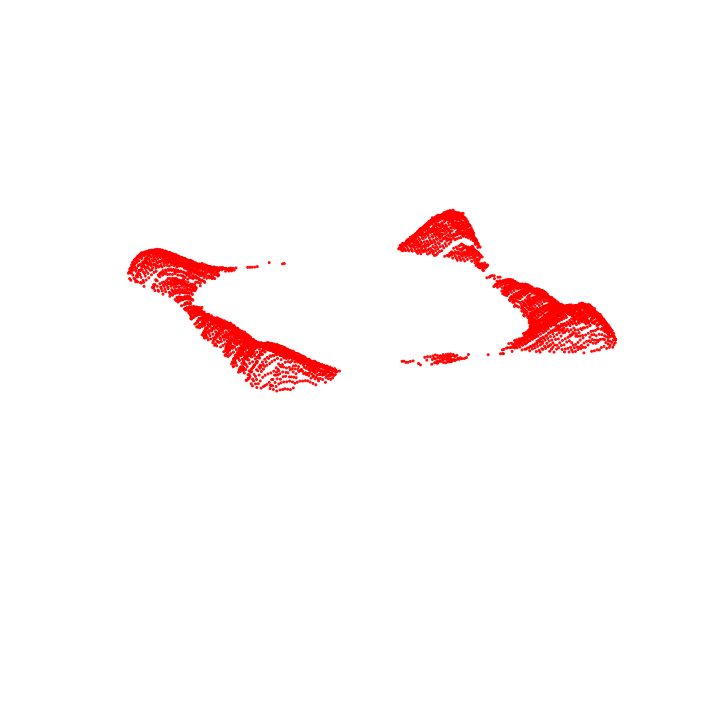

In [11]:
x_seg = points_segmented[:,0]
y_seg = points_segmented[:,1]
z_seg = points_segmented[:,2]



plt.figure(figsize=(10, 10))
# plt.figure()
ax = plt.axes(projection='3d')

# ax.plot_wireframe(X, Y, Z, color='gray', alpha = 0.6)
# Data for three-dimensional scattered points, extracted from numpy array
# p = ax.scatter3D(x_seg, y_seg, z_seg, c=z_seg, cmap = 'jet', s = 4, alpha = 0.9); # other cmap options: winter, Greens
p = ax.scatter3D(x_seg, y_seg, z_seg, c='r', s = 4, alpha = 0.9);
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)

ax.set_zlim(-1.5, 3)
# plt.title('3D Point cloud and reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph

ax._axis3don = False

save_fig("step3_point cloud below the reference plane")

## Extract the 2D projected points from the segmented cloud

the point cloud projected on the 2D plane: 
[[-11.73016925 -14.67086971   1.31625561]
 [-11.49780925 -14.65583685   1.31625561]
 [-12.49975285 -14.52054742   1.31625561]
 ...
 [ 12.0776545   13.18580701   1.31625561]
 [ 12.26074167  13.1871676    1.31625561]
 [ 11.68067066  13.40103275   1.31625561]]
point_extracted shape: (4993, 3)


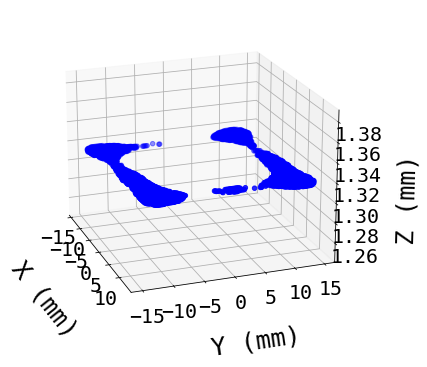

In [12]:
## set the z = z_segment for all the points
point_extracted = points_segmented
point_extracted[:,2] = z_segment
print("the point cloud projected on the 2D plane: ")
print(point_extracted)
print ("point_extracted shape: " + str(point_extracted.shape))


x_2d = point_extracted[:,0]
y_2d = point_extracted[:,1]
z_2d = point_extracted[:,2]



plt.figure(figsize=(6,6))
# plt.figure()
ax = plt.axes(projection='3d')


# ax.plot_wireframe(X, Y, Z, color='gray')
# Data for three-dimensional scattered points, extracted from numpy array
ax.scatter3D(x_2d, y_2d, z_2d, c=z_2d, cmap='winter'); # other cmap options: winter, Greens
# cbar = plt.colorbar(p)
# cbar.ax.set_ticks(np.arange(0, 2, 0.5))
# cbar.set_label("Z Height (mm)", fontsize=16, labelpad=15)
ax.set_xlabel('X (mm)', fontsize=25, labelpad=25)
ax.set_ylabel('Y (mm)', fontsize=25,labelpad=25)
ax.set_zlabel('Z (mm)', fontsize=25, labelpad=20);
# ax.set_zticks([1, 1.5, 2])
# ax.set_xticks([-20, -10, 0, 10, 20])
# ax.set_yticks([-30, -20, -10, 0, 10, 20, 30])

for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(20)
for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(20)



# plt.title('point cloud projected onto the 2D reference plane')
ax.view_init(elev=20,azim=-20) #rotate the graph
#‘elev’ stores the elevation angle in the z plane. ‘azim’ stores the azimuth angle in the x,y plane.
# save_fig('step_4 point cloud projected onto the 2D reference plane')

In [13]:
import time
t0 = time.monotonic()

## Convert all points into 2D points, remove the thrid dimension

In [14]:
print ("point_extracted number of points: " + str(point_extracted.shape[0]))
point_2D_extracted = np.zeros((point_extracted.shape[0], 2))
point_2D_extracted[:, 0] = point_extracted[:, 0]
point_2D_extracted[:, 1] = point_extracted[:, 1]
print ("point_2D_extracted dimensin: " + str(point_2D_extracted.shape))

point_extracted number of points: 4993
point_2D_extracted dimensin: (4993, 2)


## Using Sklearn DBSCAN clustering

In [15]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from matplotlib import transforms

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.8, min_samples=10).fit(point_2D_extracted)
# db = DBSCAN(eps=1, min_samples=10).fit(extracted_2D_downsampled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 18


Saving figure step5_DBSCAN clustering by SKlearn (black points are noise which do not belong to any cluster)


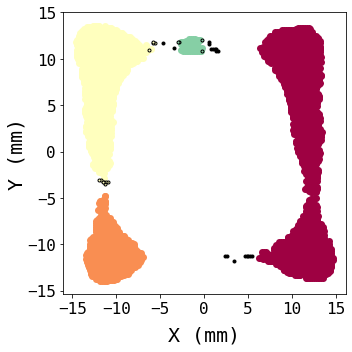

In [16]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))


### rotate figure -
# first of all, the base transformation of the data points is needed
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(90)


## set colors for differnt labels
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

# colors = ['r','g','b','c','y']

point_clusters = []
cluster = 0 
while cluster < n_clusters_:
    
    class_member_mask = (labels == cluster)
    point_clusters.append(point_2D_extracted[class_member_mask & core_samples_mask])
#     point_clusters.append(extracted_2D_downsampled[class_member_mask & core_samples_mask])
    cluster = cluster + 1

    
    
    
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
#     point_clusters[k] =  point_2D_extracted[class_member_mask & core_samples_mask]
   
    xy = point_2D_extracted[class_member_mask & core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14)
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='None', markersize=14, transform= rot + base)

    # these are the points does not belong to either clusters (noise)
    xy = point_2D_extracted[class_member_mask & ~core_samples_mask]
#     xy = extracted_2D_downsampled[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], '.', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, transform= rot + base)

plt.xlabel('X (mm)', fontsize=20, labelpad=10)
plt.ylabel('Y (mm)', fontsize=20, labelpad=1)
# plt.xticks(np.arange(-10, 10, 10))
#--------------------------------------------------
# plt.xticks([-20, -10, 0 , 10, 20], fontsize = 16) 
# plt.yticks([-10, 0, 10], fontsize = 16)
#--------------------------------------------------
plt.xticks([-15, -10, -5 , 0, 5, 10, 15], fontsize = 16) 
plt.yticks([-15, -10, -5 , 0, 5, 10, 15], fontsize = 16)


# plt.title('Estimated number of clusters: %d' % n_clusters_)
save_fig("step5_DBSCAN clustering by SKlearn (black points are noise which do not belong to any cluster)")
plt.show()

In [17]:
print("the dimension of the point cloud cluster: " + str(point_clusters[0].shape))

the dimension of the point cloud cluster: (2468, 2)


## Get the contour of each point cloud clusters

### Example : (from online)
https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation

## Concave hull (polygon fitting) based on Python Shapely
---- This one will be chosen

### 1. ConcaveHull.py from https://gist.github.com/AndreLester/589ea1eddd3a28d00f3d7e47bd9f28fb
http://www.rotefabrik.free.fr/concave_hull/

Advantage: fast, directly give the boundaries of edges with points in numpy array format

### visualization (cluster 0)

- Hyperparameter for tuning: tol (equivalent to alpha value)

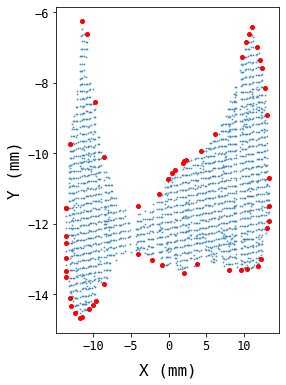

(54, 2)


In [18]:
# from ConcaveHull import ConcaveHull

ch = ConcaveHull()
# pts = np.random.uniform(size=(100, 2))
pts = point_clusters[0]
ch.loadpoints(pts)
ch.calculatehull(tol = 5)     ## a hyperparameter for tuning

boundary_points = np.vstack(ch.boundary.exterior.coords.xy).T
# boundary_points is a subset of pts corresponding to the concave hull
# Computing the alpha shape

# Plotting the output
plt.figure(figsize=(4, 6))
plt.plot(point_clusters[0][:, 0], point_clusters[0][:, 1], '.', ms = 2, alpha = 0.6)
plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'r.', ms = 8)

plt.xlabel('X (mm)', fontsize=16, labelpad=10)
plt.ylabel('Y (mm)', fontsize=16, labelpad=5)
# plt.xticks(np.arange(-10, 10, 10))
# plt.xticks([-10, 0, 10]) 
# plt.yticks([-20, -10, 0 , 10, 20])


# plt.title("Boundary point of of the point cluster 0 \n (the boundary points in red)")
# save_fig("Step6.4- Get the contour of the point cluster (return the boundary points in red) - Cluster0")
plt.show()

# print (boundary_points)
print (boundary_points.shape)

### plot the whole picture edges (polygon boundary) with point cloud clusters and bounding box

Saving figure boundary points extraction


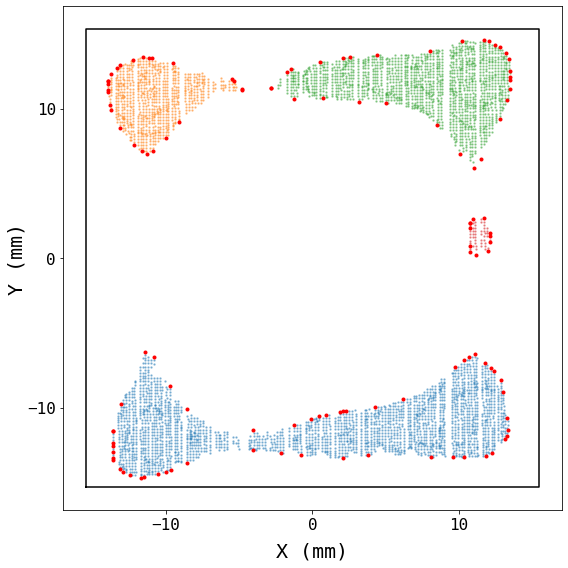

In [19]:
# return a list of points define cluster boundary
interior_boundary_points = calculate_polygon_bondary_with_point_clusters(point_clusters)
save_fig("boundary points extraction")

Saving figure boundary lines extraction


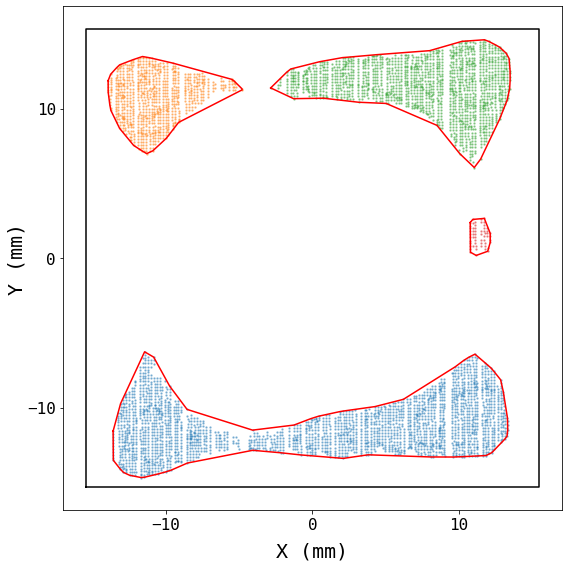

In [20]:
interior_boundary_points = calculate_polygon_bondary_with_point_clusters(point_clusters, lines = True)
save_fig("boundary lines extraction")

# Tool path generation

# Polygon infill path generate

https://stackoverflow.com/questions/61853250/polygon-infill-path-generate

https://stackoverflow.com/questions/15668149/polygon-infill-algorithm

https://github.com/Tannz0rz/Mandoline

https://www.mathworks.com/matlabcentral/answers/158900-plotting-zigzag-in-a-2d-contour

https://github.com/nahyunkwon/gcode-modification/blob/87e896818704765201d1f3bcf8604f44d23338fa/adhesion_structure.py

# 1. Python inpolygon function
- Need to find a suitable function performing "inpolygon" equivalent as matlab
- Matlab inpolygons function:  
   - It allows the input polygon vertices to describe multiple NaN-delimited polygons. 
   - The polygons can also include holes.  
   - returns true/ false to tell if the points are lie in the polygon

##  Shapely
https://gis.stackexchange.com/questions/170264/python-point-in-polygon-boundary-and-vertex-check-ray-casting

https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates

In [21]:
## create a polygon object using 'boundary_points'
polygon = Polygon(boundary_points)

## Polygon with hole (shapely)

- given __outer__ as a plain Polygon and __inners__ as a list of plain Polygons (each of them contained in outer) :

- Polygons

class Polygon(shell[, holes=None])
The Polygon constructor takes two positional parameters. The first is an ordered sequence of (x, y[, z]) point tuples and is treated exactly as in the LinearRing case. The second is an optional unordered sequence of ring-like sequences specifying the interior boundaries or “holes” of the feature.



## __figures.py__ -- an utility function downloaded from shapely.figures.py

https://raw.githubusercontent.com/Toblerity/Shapely/master/docs/code/figures.py

## Testing with our example -- Plot the polygon with clustered bulge area as holes

In [22]:
def plot_filled_polygons(polygons, facecolour='green', edgecolour='black', linewidth=1, alpha=0.5):
        """
        This function plots a series of shapely polygons but fills them in

        Args:
            ax_list: list of axes
            polygons: list of shapely polygons

        Author: FJC
        """
        print('Plotting the polygons...')

        #patches = []
        for key, poly in polygons.items():
            this_patch = PolygonPatch(poly, fc=facecolour, ec=edgecolour, alpha=alpha)
            self.ax_list[0].add_patch(this_patch)

In [23]:
boundary_points[0]

array([-13.62705298, -11.56680984])

Saving figure polygon fitting


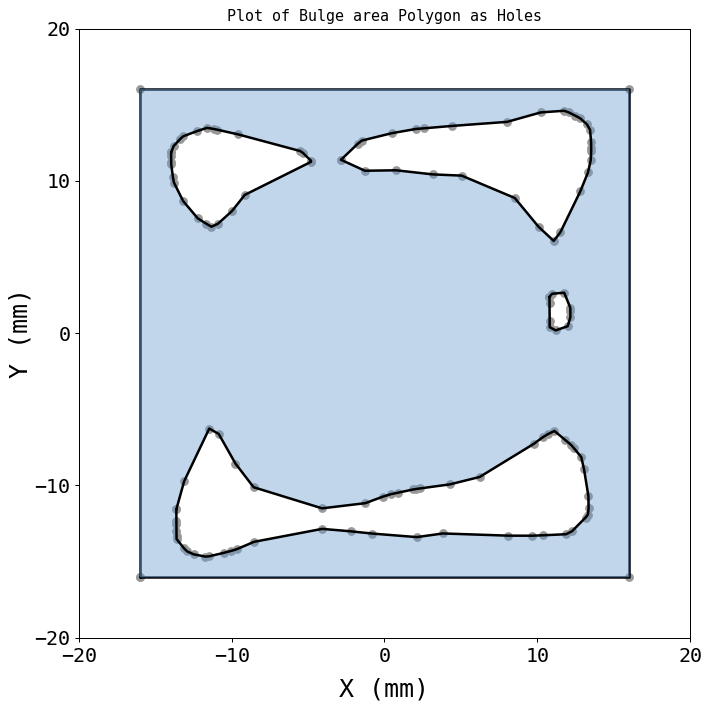

In [24]:
# Define exterior boundary CCW direction
# ext = [(-10.5, -20.5), (10.5, -20.5), (10.5, 20.5), (-10.5, 20.5), (-10.5, -20.5)] ## this is for point_cloud_example
ext = [(-16, -16), (16, -16), (16, 16), (-16, 16), (-16, -16)]
polygon = visualize_bulge_area(interior_boundary_points, ext)
save_fig("polygon fitting")

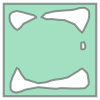

In [25]:
polygon

# 2. Line In Polygon 
### -- looks at a straight line and a closed polygon and determines which segments of the line are located inside the polygon.

## 2.1 determine the line and polygon intersection point
And also the vertices of the edge of the polygon where line intersects

https://gis.stackexchange.com/questions/339409/find-the-vertices-of-the-edge-of-the-polygon-where-line-intersects-using-shapely

In [26]:
from shapely.wkt import loads
lin = loads('LineString (289.63171806167395061 -200.22555066079294761, 380.69030837004402201 -65.28898678414094547)')
pol = loads('Polygon ((112.23259911894263041 -229.94933920704846742, 178.75726872246687549 -113.4132158590308137, 309.44757709251092592 -114.35682819383258391, 376.44405286343607031 -230.42114537444933831, 305.67312775330390195 -344.59823788546259493, 176.39823788546246419 -345.07004405286346582, 112.23259911894263041 -229.94933920704846742))')

# the LinearRing
from shapely.geometry import LineString
polin = LineString(list(pol.exterior.coords))

# intersection 
pt = polin.intersection(lin)
print(pt.wkt)


POINT (327.0268317294637 -144.8110298888352)


- iterate through the edges of the LinearRing of the polygon
- Now using Determine if Shapely point is within a LineString/MultiLineString 

(using the answer of Mike T using the distance with an appropriate threshold 
because there are floating point precision errors when finding a point on a line)

### Implementation in our scenario

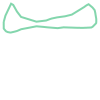

In [27]:
line_example = LineString([(-5, -20), (-5.1, 20)])

poly_lines_exterior = LineString(list(polygon.exterior.coords))
poly_lines_holes_0 = LineString(list(polygon.interiors[0].coords))
# poly_lines_holes_1 = LineString(list(polygon.interiors[1].coords))
poly_lines_holes_0

MULTIPOINT (-5.021964994206359 -11.21400231745658, -5.017422878320044 -13.03084867198226)


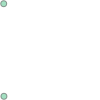

In [28]:
intersection_point = poly_lines_holes_0.intersection(line_example)
print(intersection_point.wkt)
intersection_point

In [29]:
poly_lines = [1]
poly_lines = list(polygon.exterior.coords)

for interior in polygon.interiors: 
    poly_lines.append(list(interior.coords))
#     print (list(interior.coords))
#     print ("\n")

Access the members of a MultiLineString object

- Its members are instances of LineString and are accessed via the geoms property or via the iterator protocol using in or list().

### Find intersection point for a random line with the given polygon with holes

In [30]:
line_example = LineString([(5, -23), (5.1, 23)])

## 2.2 Line polygon segmentation

- Developing the python function for line in polygon 

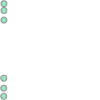

In [31]:
intersection_points = LinePolygonIntersectionPoints(line_example, polygon)
intersection_points

### visualize polygon - line intersection

## sorts the rows of intPoints in ascending order based on the elements in the first column

https://www.kite.com/python/answers/how-to-sort-the-rows-of-a-numpy-array-by-a-column-in-python

### Implement the sorting multi point function 

### Line in polygon segmentation function

sorting multi point 
https://gis.stackexchange.com/questions/338460/reversing-coordinates-of-multipoint-using-shapely

In [32]:
line_segment_in_mutiline, line_segment_out_mutiline = LineInPolygonSegmentation(line_example, polygon)

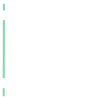

In [33]:
line_segment_in_mutiline

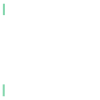

In [34]:
line_segment_out_mutiline

## plot another example line intersection

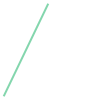

In [35]:
line_example2 = LineString ([(-10.1,-21),(10.1,21)])
line_example2

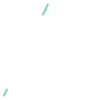

In [36]:
intersection_points2  = LinePolygonIntersectionPoints(line_example2, polygon)
line_segment_in_2, line_segment_out_2 = LineInPolygonSegmentation(line_example2, polygon)
line_segment_out_2

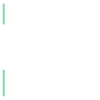

In [37]:
line_example3 = LineString ([(-11,-21),(-11,21)])
# intersection_points3  = LinePolygonIntersectionPoints(line_example3, polygon)
line_segment_in_3, line_segment_out_3 = LineInPolygonSegmentation(line_example3, polygon)
line_segment_out_3

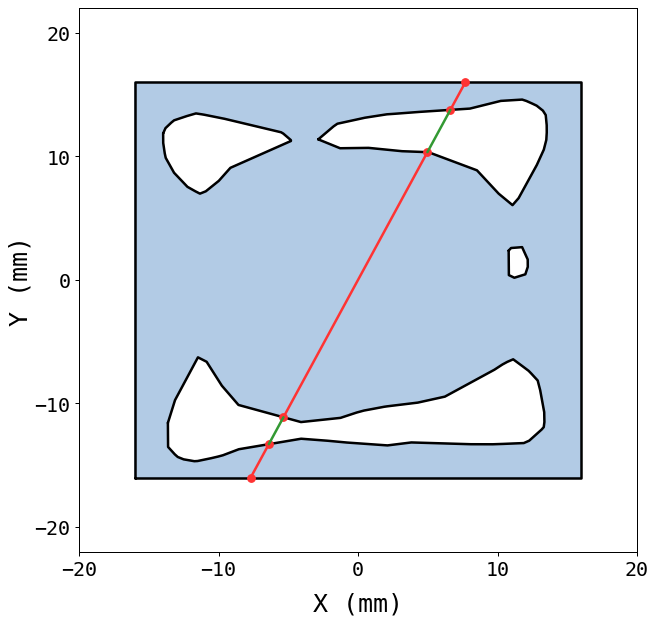

In [38]:
utils_functions.visualize_line_polygon_segmentation(polygon, intersection_points2, line_segment_in_2, line_segment_out_2)

## BufferM2 Algorithm: Computes buffer zone around a polygon

polygon.buffer(value)

value +
- make the hole smaller, 
- make the exterior countour bigger


value -
- make the hole bigger, 
- make the exterior countour smaller

#### Shapely buffer function 

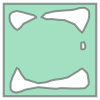

In [39]:
polygon.buffer(0)

In [40]:
polygon.interiors[0].coords

In [41]:
polygon.exterior.coords[0]

(-16.0, -16.0)

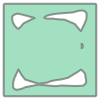

In [42]:
## buffer 0.2 unit (not in meters)
polygon_buffered = polygon.buffer(0.5)
polygon_buffered

In [43]:
# polygon_buffered.interiors[0].coords[0]

In [44]:
polygon_buffered.exterior.coords[0]

(-16.5, -16.0)

## Create Zig-Zag Tool Path

In [45]:
## Create lines and requried parameters
delta_x = 1    ## delta_x determines the intervals of lines in x direction

delta_y = 1000  ## the dx/dy determins the slope of the lines, larger delta_y gives more vertical lines

nl = 150 ## % Could probably calculate this

In [46]:
# poly_lines = list(polygon.exterior.coords)
x_countour = tuple([point.x for point in MultiPoint(polygon.exterior.coords)])
y_countour = tuple([point.y for point in MultiPoint(polygon.exterior.coords)])

In [47]:
print (x_countour)

(-16.0, 16.0, 16.0, -16.0, -16.0)


In [48]:
import math

# MATLAB:
# xe = floor(min(xc)./dx)*dx + (0:(nl-1))*dx;
# ye = sort(ceil(max(yc)./dy)*dy - (0:(nl-1))*dy);

x_extended = []
y_extended = []

# this means 0,1,2,.... nl-1, there are nl numbers in total
for n in range(nl): 
    # floor returns floor of x - the largest integer not greater than x
    xe = math.floor(min(x_countour) / delta_x) * delta_x + n * delta_x
    ye = math.ceil(max(y_countour) / delta_y) * delta_y - n *delta_y
    x_extended.append(xe)
    y_extended.append(ye)
    
y_extended.sort()

In [49]:
y_extended[-1] # the last number from this list

1000

In [50]:
# convert the list to array
test_array = np.array([x_extended])
test_array.shape

(1, 150)

In [51]:
# convert to numpy array and also reverse the direction
test_array = np.array([y_extended[::-1]])
test_array.shape
# test_array

(1, 150)

In [52]:
# MATLAB
# xa = xe;
# ya = ones(1,nl).*ye(end);
# xb = ones(1,nl).*xe(1);
# yb = ye(end:-1:1); % Reverse the order of elements

# xl = [xa; xb];
# yl = [ya; yb];

'''
xa, ya gives a horizontal line y=1000, while x ranges from -11 to 137 (interval 1)

xb, yb gives a vertical line x = -11, while y ranges from 1000 to -147000 (interval 1000)
'''

xa = np.array([x_extended])
ya = np.ones((1, nl)) * y_extended[-1]
xb = np.ones((1, nl)) * x_extended[0]
yb = np.array([y_extended[::-1]])


xl = np.concatenate((xa, xb))
yl = np.concatenate((ya, yb))

## Integrate the grid line creation function

In [53]:
line_elements = grid_line_creation(polygon_buffered, delta_x = 1, delta_y = 1000, nl = 150)
line_elements2 = grid_line_creation(polygon_buffered, delta_x = 4, delta_y = 1000, nl = 150)
line_elements3 = grid_line_creation(polygon_buffered, delta_x = 1, delta_y = 5, nl = 150)
line_elements4 = grid_line_creation(polygon_buffered, delta_x = 2, delta_y = 2, nl = 150)
line_elements5 = grid_line_creation(polygon_buffered, delta_x = 4, delta_y = 4, nl = 150)
line_elements6 = grid_line_creation(polygon_buffered, delta_x = 2, delta_y = 0.5, nl = 150)

In [54]:
len(line_elements)

150

## visualize the line grid we created

In [55]:
line_elements_list = [line_elements, line_elements2, line_elements3, line_elements4,line_elements5, line_elements6]
# visualize_grid_line_generation(line_elements_list)

### Zig-zag the lines

In [56]:
line_segment_in, line_segment_out = LineInPolygonSegmentation(line_elements[5], polygon_buffered)

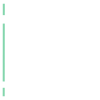

In [57]:
list_lines = []
for line in line_segment_in.geoms:
    list_lines.append(line)
    
list_line_reversed = list_lines[::-1]
reversed_segment = MultiLineString(tuple(list_line_reversed))
reversed_segment

In [58]:
segment_inside_collection_test = [] # empty list
line_segment_in = reverse_MultiLineString(line_segment_in)
segment_inside_collection_test.append (line_segment_in)

line_segment_in2, line_segment_out2 = LineInPolygonSegmentation(line_elements[3], polygon_buffered)
segment_inside_collection_test.append (line_segment_in2)
segment_inside_collection_test

In [59]:
ine_segment_in, ine_segment_out = LineInPolygonSegmentation(line_elements[0], polygon_buffered)

- polygon_buffered --- the output of bufferm2 function (shapely polygon.buffer function equivalent)
- xl, yl -- created lines

In [60]:
# line_elements = grid_line_creation(polygon, delta_x = 1, delta_y = 1000, nl = 150)

dirr = True
segment_inside_collection = [] # empty list

# from 0 to nl-1
for i in range (nl):
#     intersection_points2  = LinePolygonIntersectionPoints(line_example2, polygon_buffered)
    line_segment_in, line_segment_out = LineInPolygonSegmentation(line_elements5[i], polygon_buffered)
    
    # if there is intersection between polygon and line
    if (line_segment_in is not None):
        if (dirr):
            segment_inside_collection.append (line_segment_in)
        else:
            segment_inside_collection.append (reverse_MultiLineString(line_segment_in))
        dirr = ~dirr

## Integrate the zig-zag line segmentation function

In [61]:
# segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements, polygon_buffered, nl = nl)

## Visualize the final results

In [62]:
# visualize_grid_polygon_segmentation(polygon_buffered, segment_inside_collection, segment_out_collection, intersection_points_collection)

# Visaulization - Example 2 (change parameters dx)

In [63]:
segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements2, polygon_buffered)

Saving figure toolpath generation 1


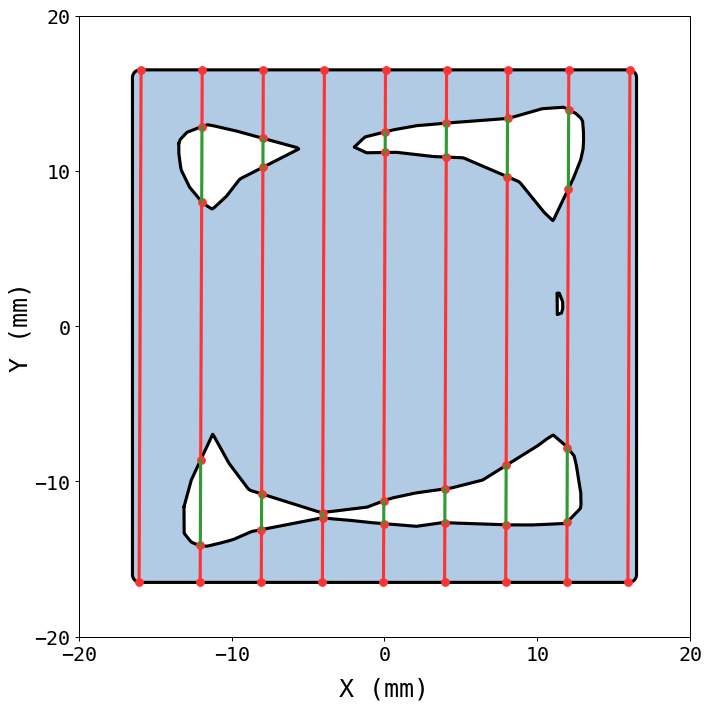

In [64]:
visualize_grid_polygon_segmentation(polygon_buffered, segment_inside_collection, segment_out_collection, intersection_points_collection)
save_fig("toolpath generation 1")

In [65]:
# segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements4, polygon_buffered)

In [66]:
# visualize_grid_polygon_segmentation(polygon_buffered, segment_inside_collection, segment_out_collection, intersection_points_collection)

In [67]:
segment_inside_collection, segment_out_collection, intersection_points_collection = zig_zag_segmentation(line_elements5, polygon_buffered)

Saving figure toolpath generation 2


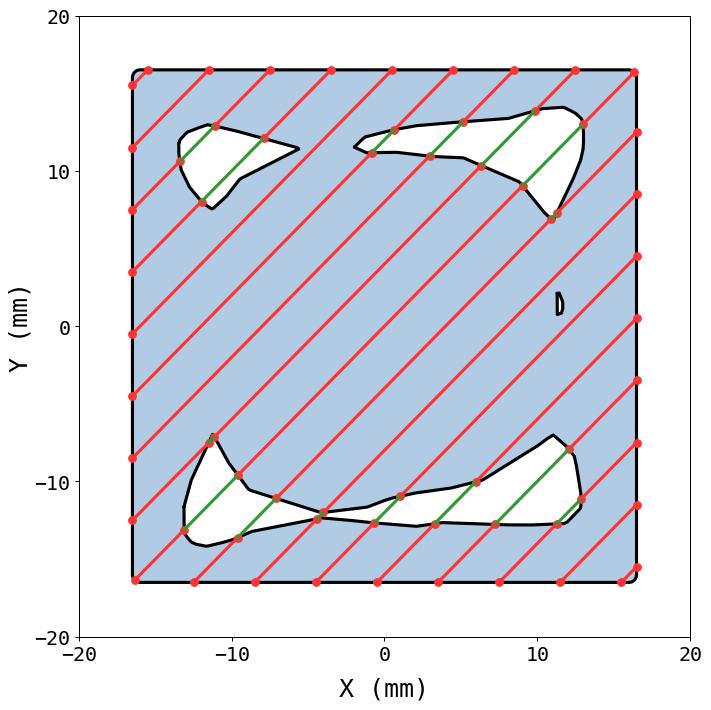

In [68]:
visualize_grid_polygon_segmentation(polygon_buffered, segment_inside_collection, segment_out_collection, intersection_points_collection)
save_fig("toolpath generation 2")

In [69]:
t1 = time.monotonic()
print (t1 - t0)

3.6410000000032596
